## 다양한 이미지 처리 방법 - 자동차 번호판 박스 표시

In [1]:
!pip install pytesseract

### 차량 이미지 불러오기

이미지 크기 >>  720 960 3


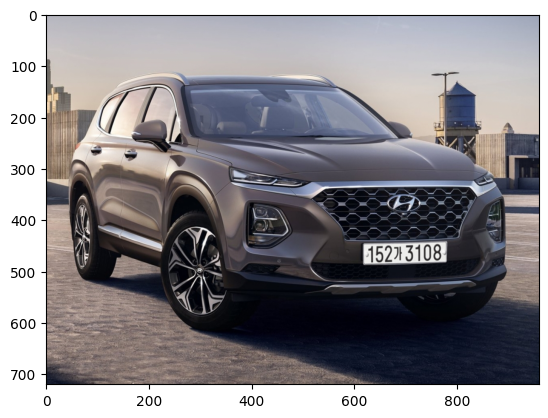

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract           # 이미지 안에 있는 문자 추출

image_path = './data/car2.png'

# 이미지 읽기
image = cv2.imread(image_path)

# 색상의 문제 발생 BGR >> RGB 컨버터
image = cv2. cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, channel = image.shape
print("이미지 크기 >> ", height, width, channel)

plt.imshow(image)
plt.show()

### 차량 이미지 Grayscale 변환

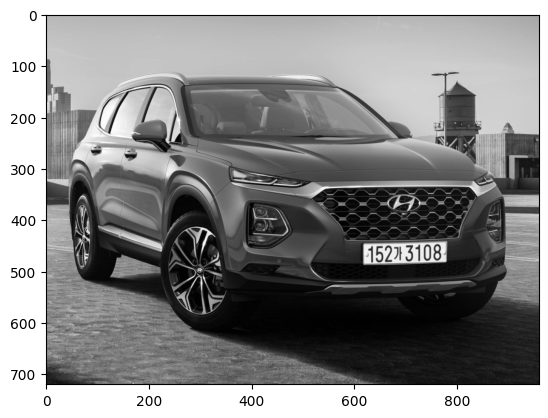

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, 'gray')
plt.show()

### 차량 이미지 Maximize contrast
콘트라스트 최대화는 일반적으로 이미지나 시각적 디스플레이에서 가장 어두운 부분과 밝은 부분의 차이를 높여 이미지의 선명도 올림

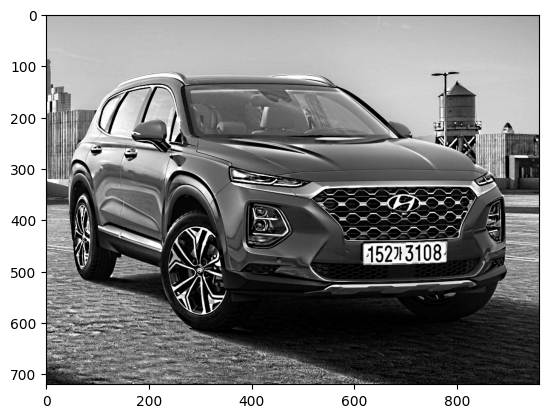

In [4]:
# 모폴로지 연산
# 9x9 크기의 직사각형 형태의 구조 요소를 생성하여 structuringElment 변수에 할당
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))

# TOPHAT -> 밝기 값이 크게 변화하는 영역을 강조
imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)
# BLAXKHAT -> 어두운 부분 강조
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)

# cv2.add -> 두 영상의 같은 위치에 존재하는 픽셀 값을 더하여 결과 영상의 픽셀 값으로 설정한다.
imgGrayscalePlusTopHat = cv2.add(gray_image, imgTopHat)
# cv2.subtract

"""
뺄셈 연산 - cv2.subtract
두 영상의 같은 위치에 존재하는 픽셀 값에 대해 뺄셈 연산을 수행해 결과 영상의 픽셀 값으로 설정한다.
뺄셈 결과가 0보다 작으면 픽셀 값을 0으로 설정한다. (saturate 연산)
"""

gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.imshow(gray, 'gray')
plt.show()

### 차량 이미지 이진화 (Adaptive Thresholding)

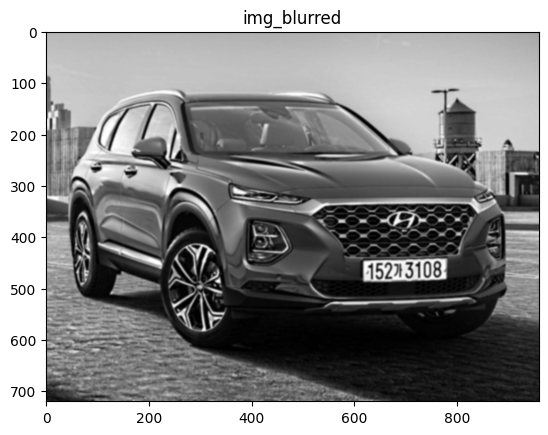

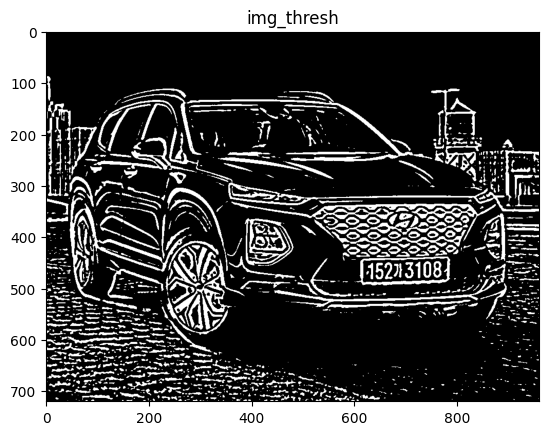

In [5]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX = 0)

plt.imshow(img_blurred, 'gray')
plt.title('img_blurred')
plt.show()


"""
Gaussian Adaptive Thresholding : 주변 픽셀의 가중 평균값을 사용하는 방법으로,
평균값 대신 가중 평균값을 사용하므로 주변 픽셀이 픽셀에 더 큰 영향을 미친다.
주변 픽셀의 가중 평균값이 픽셀의 밝기 값보다 작으면 픽셀 값을 0으로, 그렇지 않으면 255로 설정한다.
"""

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 19,
    C=9
)

plt.imshow(img_thresh, 'gray')
plt.title('img_thresh')
plt.show()

### 차량 이미지 Find Contours (이미지에서 객체의 외각선 검출)
영상처리에서 사용되는 기술로, 이미지에서 객체의 외곽선을 검출하는 과정을 말한다. 

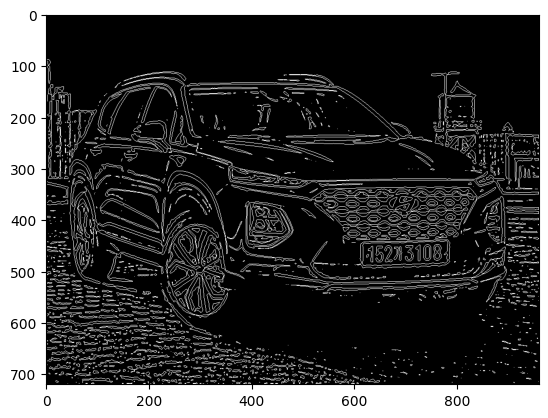

In [6]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# contours 그리기
cv2.drawContours(temp_result, contours=contours, contourIdx = -1, color=(255, 255, 255))

plt.imshow(temp_result, 'gray')
plt.show()

## 차량 이미지 전처리 (바운딩 박스 표시)

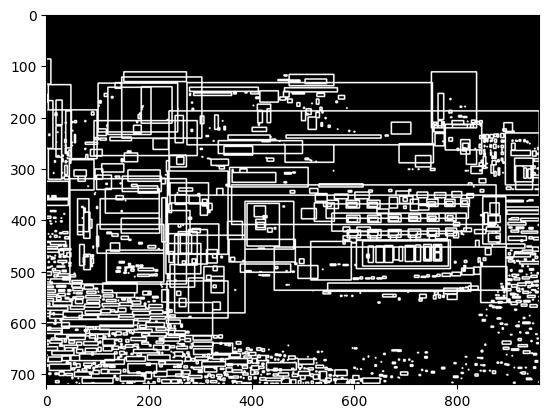

In [7]:
temp_result = np.zeros((height, width, channel), dtype = np.uint8)

contours_dict = []

for contour in contours :
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x+(w/2),
        'cy' : y+(h/2)
    })
    
plt.imshow(temp_result, 'gray')
plt.show()

## 차량 이미지 Select Candidates by Char Size 변환
Select Candidates by Char Size는 문자의 크기에 따라 후보를 선택하는 작업을 의미한다. 주로 문자 인식(OCR)이나 문자 검출(Text Detection)과 같은 작업에서 사용된다. 문자 이식이나 문자 검출 작업에서는 이미지에서 문자 영역을 찾아내고, 이를 후보로 선정하는 과정이 필요하다.<br>
이 때 문자의 크기는 후보 선정의 중요한 기준 중 하나가 될 수 있다.

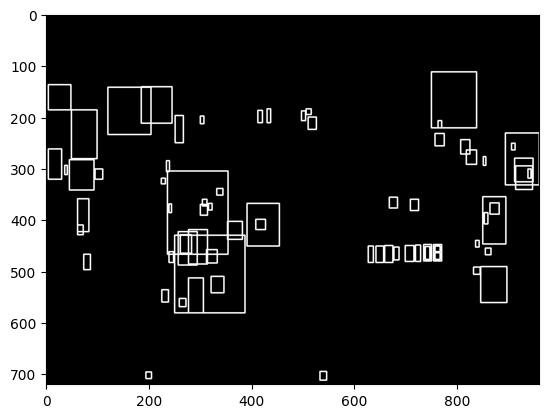

In [8]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area=d['w'] * d['h']
    ratio=d['w'] / d['h']
    
    if area > MIN_AREA \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours :
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
    
plt.imshow(temp_result, 'gray')
plt.show()

[{'contour': array([[[198, 696]],

       [[197, 697]],

       [[196, 697]],

       [[194, 699]],

       [[194, 700]],

       [[196, 702]],

       [[196, 703]],

       [[198, 705]],

       [[199, 705]],

       [[200, 706]],

       [[201, 706]],

       [[203, 708]],

       [[204, 708]],

       [[204, 707]],

       [[201, 704]],

       [[199, 704]],

       [[198, 703]],

       [[198, 702]],

       [[199, 701]],

       [[200, 701]],

       [[201, 700]],

       [[201, 698]],

       [[199, 696]]], dtype=int32), 'x': 194, 'y': 696, 'w': 11, 'h': 13, 'cx': 199.5, 'cy': 702.5, 'idx': 0}, {'contour': array([[[541, 695]],

       [[541, 697]],

       [[542, 698]],

       [[542, 699]],

       [[541, 700]],

       [[541, 701]],

       [[539, 703]],

       [[536, 703]],

       [[535, 702]],

       [[535, 703]],

       [[534, 704]],

       [[534, 709]],

       [[533, 710]],

       [[535, 710]],

       [[536, 711]],

       [[536, 708]],

       [[537, 707]],

      

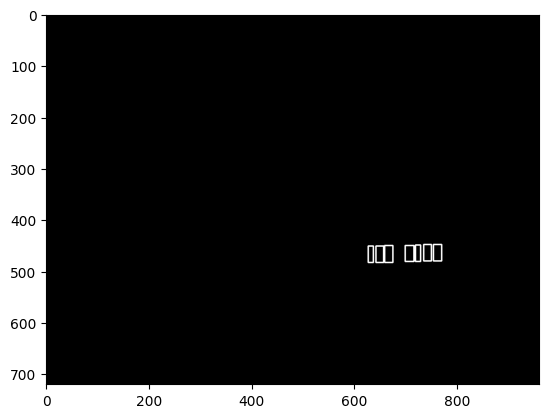

In [9]:
MAX_DIAG_MULTIPLAYER = 5 # 윤곽선 사이의
MAX_ANGLE_DIFF = 12.0 # 두 윤곽선 사이의 최대 각도 차이
MAX_AREA_DIFF = 0.5 # 두 윤곽선 사이의 최대 면적 차이
MAX_WIDTH_DIFF = 0.8 # 두 윤곽선 사이의 최대 면적 너비
MAX_HEIGHT_DIFF = 0.2 # 두 윤곽선 사이의 최대 높이에 제한 두기
MIN_N_MATCHED = 3 # 윤곽선의 최소 개수에 제한 두기

def find_chars(contour_list):
    print(contour_list)
    
    matched_result_idx = []
    
    for d1 in contour_list :
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else :
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
                
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLAYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        # append this contour
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d['idx'])
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result :
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']),
                     color=(255,255,255), thickness=2)
                      
plt.imshow(temp_result, 'gray')
plt.show()

## 차량 번호판 이미지를 회전시키는 작업
번호판의 텍스트가 특정 각도로 휘어있거나, 이미지의 촬영 조건에 따라 번호판이 기울어져 있는 경우가 있다. 이러한 번호판의 기울어짐이나 회전이 있을 경우, 문자 인식이나 객체 검출 알고리즘의 성능을 저하시킬 수 있다. 따라서 번호판 이미지를 회전시켜 수평으로 정렬하여, 후속 작업에서 정확한 문자 인식이나 객체 검출을 수행할 수 있도록 보정한다.

In [10]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x:x['cx'])
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for di in sorted_chars:
        sum_height ++ d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
        
        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
        
        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']]))

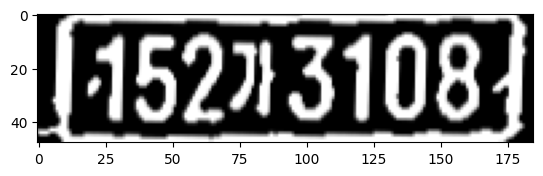

In [11]:
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize=(int(plate_width), int(plate_height)),
    center = (int(plate_cx), int(plate_cy)))

plate_imgs.append(img_cropped)
plate_infos.append({
    'x' : int(plate_cx - plate_width / 2),
    'y' : int(plate_cy - plate_height / 2),
    'w' : int(plate_width),
    'h' : int(plate_height)
})

plt.imshow(img_cropped, 'gray')
plt.show()

## 차량 번호판 Another Thresholding to Find Chars

In [14]:
longest_idx, longest_text = -1, 0
plate_chars = []

print(plate_imgs)

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, hierarchy = cv2. findContours(plate_img, mode=cv2.RETR_LIST, method = cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

[array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 56, 115, 119, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)]


cv2.copyMakeBorder : 입력 이미지 주위에 지정된 픽셀 값 또는 테두리를 추가하는 데 사용된다.

In [13]:
for coutours in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    area = w * h
    ratio = w / h
    
    if area > MIN_AREA \
    and w > MIN_WIDTH and h > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        if x < plate_min_x:
            plate_min_x = x
        if y < plate_min_y:
            plate_min_y = y
        if x + w > plate_max_x:
            plate_max_x = x + w
        if y + h > plate_max_y:
            plate_max_y = y + h
            
img_result = plate_img[plate_min_y : plate_max_y, plate_min_x : plate_max_x]

img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
_, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10,
                               borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

plt.imshow(img_result, 'gray')
plt.show()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


{'x': 604, 'y': 441, 'w': 185, 'h': 48}


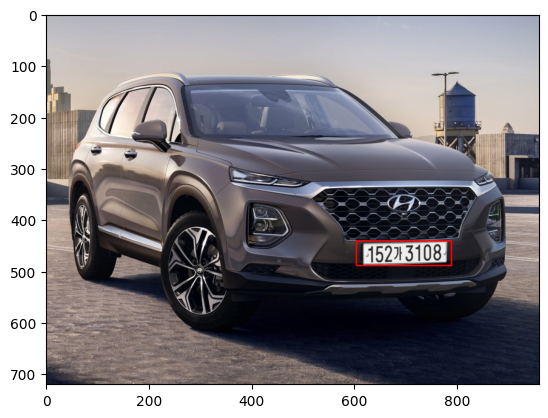

In [16]:
info = plate_infos[longest_idx]
img_out = image.copy()

print(info)
cv2.rectangle(img_out, pt1=(info['x'], info['y']),  pt2=(info['x'] + info['w'], info['y'] + info['h']),
              color = (255,0,0), thickness=2)

plt.imshow(img_out)
plt.show()